In [4]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

import random

import clustering_functions as cf

In [7]:
import os
os.chdir('.')

In [11]:
execfile('pre_processing.py')

## PCA + k-means

In [12]:
filepath_pca_kmeans='plots/pca/'

**calculate EOFs and clusters**

In [13]:
eofs_z500, variance_fraction_z500, pcs_z500 = cf.eof_analysis(z500, 10)

k=5
pca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(pcs_z500)
centroids_pca = cf.reshape_centroids_pca_kmeans(kmeans = pca_clusters, eofs = eofs_z500, pc_number = 10)

**calculate precipitation associated with each label and order labels according to that**

In [15]:
pr_labeled = cf.assign_labels(xarray_array=pr, labels=pca_clusters.labels_)
pr_by_label = pr_labeled.groupby('label').mean(dim=['time', 'latitude', 'longitude'])
cluster_order_pca = np.flip(np.argsort(pr_by_label.values)).tolist()

dict_replace = {0: cluster_order_pca.index(0), 1: cluster_order_pca.index(1), 2: cluster_order_pca.index(2), 
                3: cluster_order_pca.index(3), 4:cluster_order_pca.index(4)}

def replace(element):
    return dict_replace.get(element, element)

vfunc = np.vectorize(replace)

relabeled_labels = vfunc(pca_clusters.labels_)

d = {'Labels': 'PCA', 'Value': relabeled_labels}
df = pd.DataFrame(data=d)
df.to_csv(filepath_pca_kmeans+'relabeled_labels.csv')

**visualise clusters ordered according to amount of associated precipitation**

/Users/tyler/anaconda3/envs/IDL/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


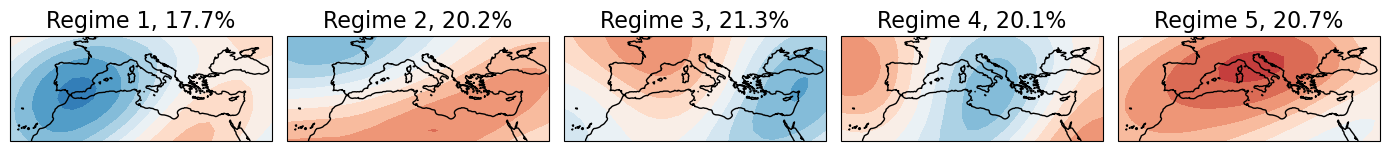

In [17]:
clusters_pca_vis = cf.visualise_contourplot(dataset_xarray = centroids_pca, 
                                                          unit = '[m]', 
                                                          cluster_results = pca_clusters, 
                                         cluster_order = cluster_order_pca,
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8'],
                                                          vmin=-1.7, vmax=1.7, steps=0.2, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False, 
                                         projection = ccrs.PlateCarree(central_longitude=0)
                                          )

plt.savefig(filepath_pca_kmeans+'cluster_visualisation_5.png')

**save cluster centers**

In [18]:
centroids_pca_flat = cf.reshape_data_for_clustering(centroids_pca)
df = pd.DataFrame(data=centroids_pca_flat)
df.to_csv(filepath_pca_kmeans+'cluster_centers_5.csv')

**calculate and plot precipitation odds ratios**

/Users/tyler/anaconda3/envs/IDL/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/tyler/anaconda3/envs/IDL/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


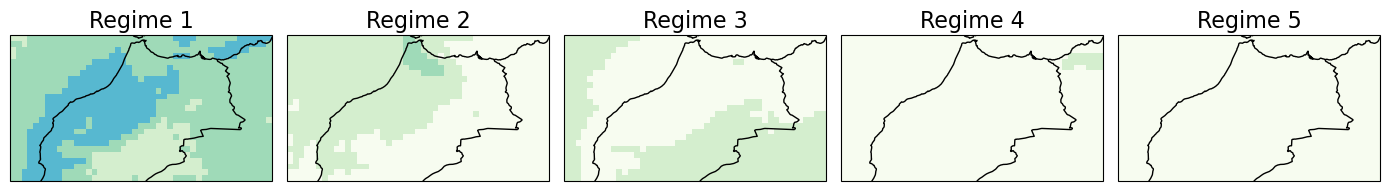

In [19]:
pr_qn95_ratio = cf.calculate_conditional_probability_change(threshold_matrix = threshold_qn95, 
                                                        kmeans = pca_clusters,
                                                       comparison = 'ratio', shift_value=0)

pr_qn95_vis = cf.visualise_spatial_oddsratio(dataset_xarray = pr_qn95_ratio, unit='',
                                          cluster_order = cluster_order_pca,
                                   color_scheme = 'GnBu', vmin = 0, vmax=6, steps=7, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                              col_number=5)

plt.savefig(filepath_pca_kmeans+'oddsratio_95_5.png')

**t-SNE plots**

In [20]:
X_embedded_z500 = TSNE(n_components=2, perplexity=30).fit_transform(pcs_z500)

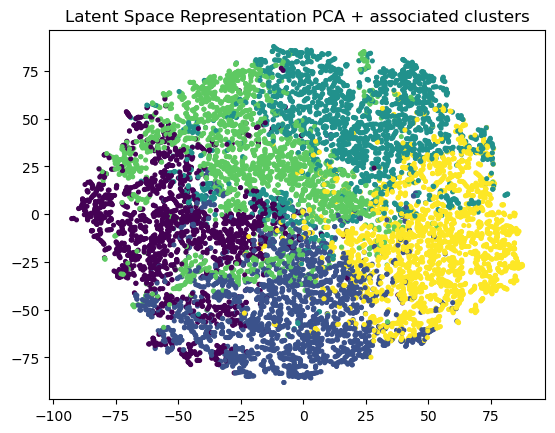

In [21]:
clusters = KMeans(n_clusters=5, n_init=50, random_state=0).fit(pcs_z500)

scatter = plt.scatter(X_embedded_z500[:,0],X_embedded_z500[:,1],c=relabeled_labels, s=7)
plt.title('Latent Space Representation PCA + associated clusters')
#plt.legend(*scatter.legend_elements())
plt.savefig(filepath_pca_kmeans+'tsne_clusters.png')

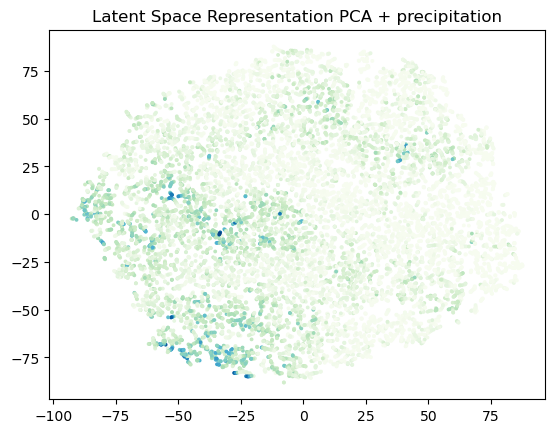

In [22]:
scatter = plt.scatter(X_embedded_z500[:,0],X_embedded_z500[:,1],c=pr_spatial.values, cmap='GnBu', s=3, alpha=1)#.get_legend().remove()
plt.title('Latent Space Representation PCA + precipitation')
#plt.legend(*scatter.legend_elements(), loc="upper right")
plt.savefig(filepath_pca_kmeans+'tsne_precipitation_nolegend.png')

**reconstruction loss**

In [23]:
reconstructed_pca = pcs_z500[:, 0]*eofs_z500[0, :, :]
for i in range(10):
    reconstructed_pca = reconstructed_pca+pcs_z500[:, i]*eofs_z500[i, :, :]

/Users/tyler/anaconda3/envs/IDL/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


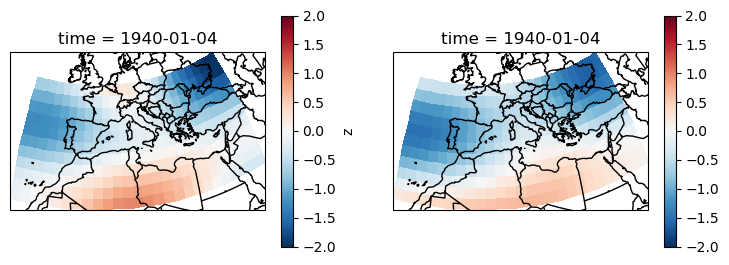

In [24]:
fig = plt.figure(figsize=[14,3])

count=3
    
ax1 = fig.add_subplot(131, projection=ccrs.Orthographic(0,45))
z500[count, :, :].plot(ax=ax1, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
ax1.coastlines()
ax1.add_feature(cartopy.feature.BORDERS)
    
ax2 = fig.add_subplot(132, projection = ccrs.Orthographic(0,45))
reconstructed_pca[count, :, :].plot(ax=ax2, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
ax2.coastlines()
ax2.add_feature(cartopy.feature.BORDERS)
plt.savefig(filepath_pca_kmeans+'reconstructed_example3.png')

In [25]:
nt,ny,nx = z500.values.shape
z500_reshaped = np.reshape(z500.values, [nt, ny*nx], order='F')
reconstructed_reshaped = np.reshape(reconstructed_pca.values, [nt, ny*nx], order='F')

mse = mean_squared_error(reconstructed_reshaped, z500_reshaped, multioutput='raw_values')
mse_reshaped = mse.reshape(ny,nx, order='F')
mse_reshaped_xr = xr.DataArray(mse_reshaped, coords=z500[0, :, :].coords, 
                     dims=z500[0, :, :].dims, attrs=z500[0, :, :].attrs)

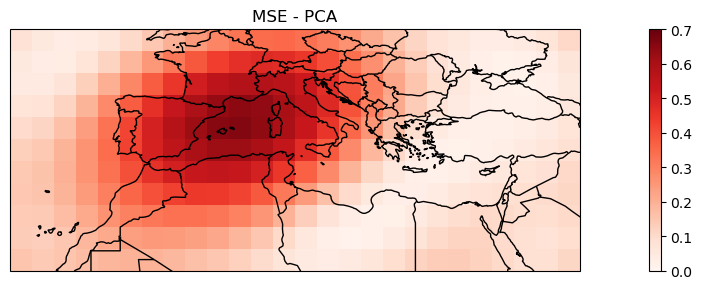

In [26]:
fig = plt.figure(figsize=[14,3])
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
mse_reshaped_xr.plot(ax=ax1, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=0.7)
ax1.coastlines()
ax1.add_feature(cartopy.feature.BORDERS)
ax1.set_title('MSE - PCA')
plt.tight_layout()
plt.savefig(filepath_pca_kmeans+'reconstructed_mse.png')

## CCA + k-means

In [27]:
filepath_cca = 'plots/cca/'

**pre-processing and CCA**

In [28]:
z500_reshaped_cca = cf.reshape_data_for_clustering(z500)
nt,ny,nx = pr_boxcox.shape
pr_reshaped_cca = np.reshape(pr_boxcox, [nt, ny*nx], order='F')

In [29]:
cca = CCA(n_components=10, scale= True, max_iter = 200)
cca.fit(z500_reshaped_cca, pr_reshaped_cca)
z500_cca, pr_cca = cca.transform(z500_reshaped_cca, pr_reshaped_cca)

**assess clusters**

In [30]:
k=5
nt,ny,nx =z500.values.shape
cca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(z500_cca)
cca_centroids_transformed = cca.inverse_transform(cca_clusters.cluster_centers_).reshape(k, ny,nx, order='F')

centroids_xr = xr.DataArray(cca_centroids_transformed, coords=z500[0:k, :, :].coords, 
                             dims=z500[0:k, :, :].dims, attrs=z500[0:k, :, :].attrs)

centroids_flat = cf.reshape_data_for_clustering(centroids_xr)
df = pd.DataFrame(data=centroids_flat)
df.to_csv(filepath_cca+'cluster_centers.csv')

**re-order cluster labels according to associated precipitation**

In [31]:
pr_labeled = cf.assign_labels(xarray_array=pr, labels=cca_clusters.labels_)
pr_by_label = pr_labeled.groupby('label').mean(dim=['time', 'latitude', 'longitude'])
cluster_order_cca = np.flip(np.argsort(pr_by_label.values)).tolist()

dict_replace = {0: cluster_order_cca.index(0), 1: cluster_order_cca.index(1), 2: cluster_order_cca.index(2), 
                3: cluster_order_cca.index(3), 4:cluster_order_cca.index(4)}

def replace(element):
    return dict_replace.get(element, element)

vfunc = np.vectorize(replace)

relabeled_labels = vfunc(cca_clusters.labels_)

d = {'Labels': 'CCA', 'Value': relabeled_labels}
df = pd.DataFrame(data=d)
df.to_csv(filepath_cca+'relabeled_labels.csv')

**visualise cluster centers**

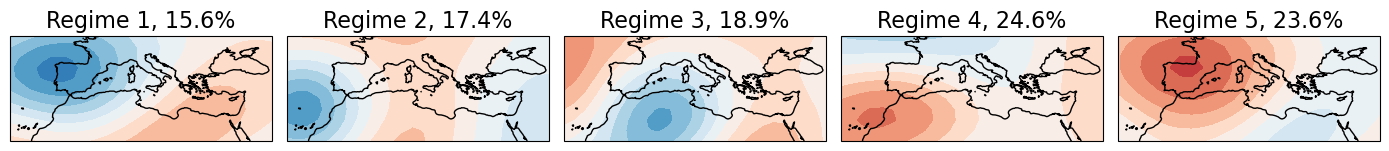

In [33]:
clusters_cca_vis = cf.visualise_contourplot(dataset_xarray = centroids_xr, 
                                                          unit = '[m]', 
                                                          cluster_results = cca_clusters, 
                                            cluster_order=cluster_order_cca,
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8'],
                                                          vmin=-1.7, vmax=1.7, steps=0.2, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False, 
                                         projection = ccrs.PlateCarree(central_longitude=0)
                                          )

plt.savefig(filepath_cca+'cluster_visualisation_5.png')

**visualise odds ratio**

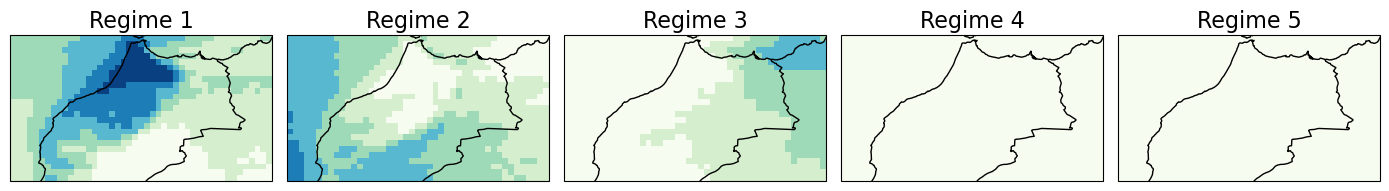

In [35]:
pr_qn95_ratio = cf.calculate_conditional_probability_change(threshold_matrix = threshold_qn95, 
                                                        kmeans = cca_clusters,
                                                       comparison = 'ratio', shift_value=0)

pr_qn95_vis = cf.visualise_spatial_oddsratio(dataset_xarray = pr_qn95_ratio, unit='', cluster_order = cluster_order_cca, 
                                   color_scheme = 'GnBu', vmin = 0, vmax=6, steps=7, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                              col_number=5)

plt.savefig(filepath_cca+'oddsratio_95_5.png')

**t-SNE**

In [36]:
X_embedded_z500_cca = TSNE(n_components=2, perplexity=30).fit_transform(z500_cca)

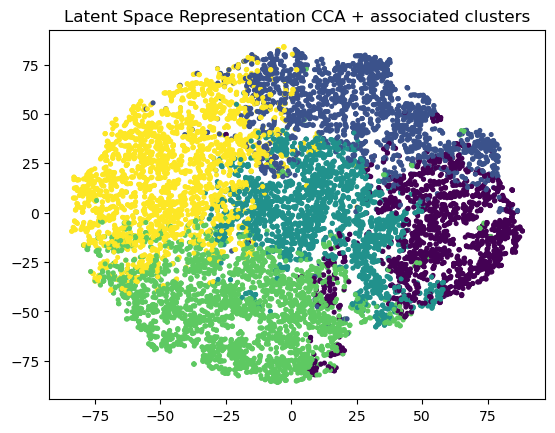

In [37]:
cca_clusters2 = KMeans(n_clusters=5, n_init=50, random_state=0).fit(z500_cca)

scatter = plt.scatter(X_embedded_z500_cca[:,0],X_embedded_z500_cca[:,1],c=relabeled_labels, s=7)
plt.title('Latent Space Representation CCA + associated clusters')
#plt.legend(*scatter.legend_elements())
plt.savefig(filepath_cca+'tsne_clusters.png')

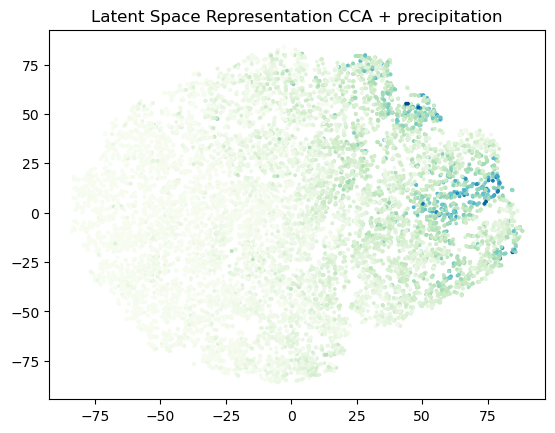

In [38]:
scatter = plt.scatter(X_embedded_z500_cca[:,0],X_embedded_z500_cca[:,1],c=pr_spatial.values, cmap='GnBu', s=3, alpha=1)
plt.title('Latent Space Representation CCA + precipitation')
#plt.legend(*scatter.legend_elements(), loc="upper left")
plt.savefig(filepath_cca+'tsne_precipitation_nolegend.png')

**reconstruction loss**

In [39]:
nt,ny,nx =z500.values.shape
reconstructed_space = cca.inverse_transform(z500_cca).reshape(nt, ny,nx, order='F')
reconstructed_xr = xr.DataArray(reconstructed_space, coords=z500.coords, 
                         dims=z500.dims, attrs=z500.attrs)

In [40]:
nt,ny,nx = z500.values.shape
z500_reshaped = np.reshape(z500.values, [nt, ny*nx], order='F')
reconstructed_reshaped = np.reshape(reconstructed_xr.values, [nt, ny*nx], order='F')


In [41]:
mse = mean_squared_error(reconstructed_reshaped, z500_reshaped, multioutput='raw_values')

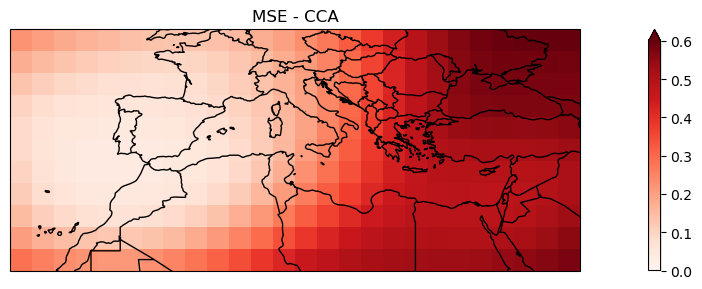

In [42]:
mse_reshaped = mse.reshape(ny,nx, order='F')
mse_reshaped_xr = xr.DataArray(mse_reshaped, coords=z500[0, :, :].coords, 
                     dims=z500[0, :, :].dims, attrs=z500[0, :, :].attrs)

fig = plt.figure(figsize=[14,3])
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
mse_reshaped_xr.plot(ax=ax1, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
ax1.coastlines()
ax1.add_feature(cartopy.feature.BORDERS)
ax1.set_title('MSE - CCA')
plt.tight_layout()
plt.savefig(filepath_cca+'reconstructed_mse.png')